## Project 1
Marc Hernandez, Tilboon Elberier

In [ ]:
pip install -r requirements.txt

In [1]:
# Importing all packages and functions needed for the assignment
import numpy as np
import matplotlib.pyplot as plt
from pickle import dump
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
# import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
from sklearn import metrics

In [2]:
# Setting the random seed variables for repeatability of results
np.random.seed(42)
random.seed(42)

In [3]:
# Importing the dataset required for 
df = pd.read_csv("Project1-ClassificationDataset.csv")
df.head()

,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,'Personalize Your NBA App Experience for the '...,'Personalize Your NBA App Experience for the '...,"['original', 'content', 'live', 'slate', 'game...",NaN,['Official Release'],https://www.nba.com/news/nba-app-new-features-...,basketball,sports
1,'Mike Will attends the Pre-GRAMMY Gala and GRA...,'Mike WiLL Made-It has secured a partnership w...,"['lead', 'espn', 'nbas', 'madeit', 'nba', 'lat...",2023-10-18 16:22:29+00:00,['Marc Griffin'],https://www.vibe.com/news/entertainment/mike-w...,basketball,sports
2,'The Golden State Warriors are struggling to f...,'The Golden State Warriors are struggling to f...,"['insider', 'york', 'thing', 'nbc', 'tag', 'nb...",NaN,[],https://www.nbcnewyork.com/tag/featured-nba/,basketball,sports
3,"'On Nov. 28, the NBA and Nike will collaborate...","'On Nov. 28, the NBA and Nike will collaborate...","['watch', 'telecast', 'ultimate', 'membership'...",NaN,['Official Release'],https://www.nba.com/news/watch-nba-games-ultim...,basketball,sports
4,'The NBA announced additions and innovations t...,'The NBA announced additions and innovations t...,"['experience', 'bring', 'media', 'crennan', 'n...",2023-10-17 12:00:17+00:00,"['Chris Novak', 'About Chris Novak']",https://awfulannouncing.com/tech/nba-app-2023-...,basketball,sports


### QUESTION 1: Provide answers to the following questions:
Overview: How many rows (samples) and columns (features) are present in the dataset? Histograms: Plot 3 histograms on :

(a) The total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis;

(b) The column leaf label – class on the x-axis; 

(c) The column root label – class on the x-axis.

Interpret Plots: Provide qualitative interpretations of the histograms.

The total number of rows in the dataframe 3476
The total number of columns (features) 8


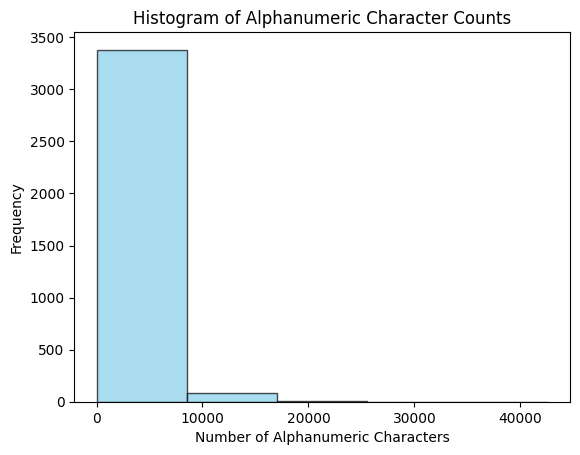

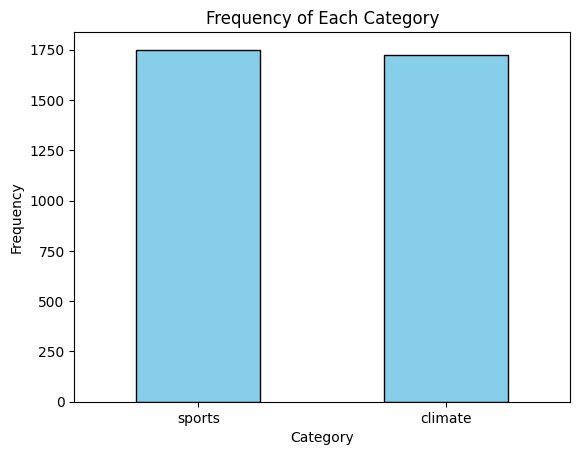

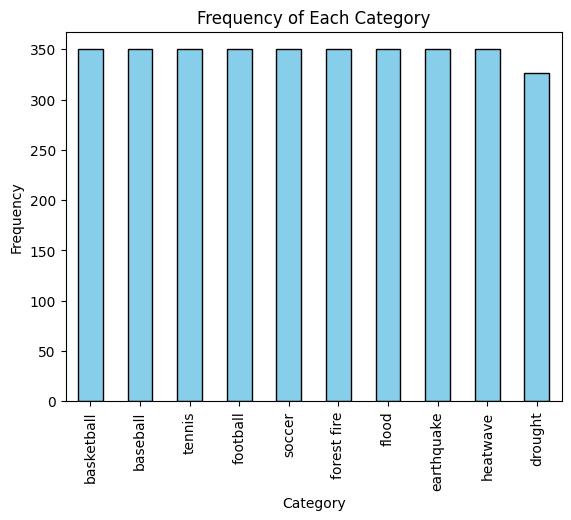

In [4]:
# Code for question 1
print("The total number of rows in the dataframe",df.shape[0])
print("The total number of columns (features)", df.shape[1])

df['count'] = df['full_text'].apply(lambda x: sum(char.isalnum() for char in x))

df['count'].plot.hist(bins=5, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Alphanumeric Character Counts')
plt.xlabel('Number of Alphanumeric Characters')
plt.ylabel('Frequency')
plt.show()

root_counts = df['root_label'].value_counts()
root_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frequency of Each Category')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep the x-axis labels horizontal
plt.show()

leaf_counts = df['leaf_label'].value_counts()
leaf_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frequency of Each Category')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Keep the x-axis labels horizontal
plt.show()

The previous histograms have provided us with the following information, part (a) demonstrates that the majority of the *full_text* feature contains entries that are within 40000 alpha-numeric characters, with a majority of the entries being less than 10000 characters. Furthermore, in the graphs (b) and (c) we can observe an even distribution of each category across all known types in our hierarchy, which enables future analysis of the data to properly weigh the features against one another due to their frequencies being nearly identical.

### QUESTION 2: Report the number of training and testing samples.

In [5]:
# Code for question 2
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)
print("The total number of smaples in the training set is", train.shape[0])
print("The total number of smaples in the testing set is", test.shape[0])

The total number of smaples in the training set is 2780
The total number of smaples in the testing set is 696


In [6]:

# Function for cleaning the entries in the full_text feature
import re
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    texter = re.sub(r'[^a-zA-Z\s]', '', texter) # added to get rid of symbols and numbers other than letter
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

### QUESTION 9: In this part, we aim to learn classifiers on the documents belonging to unique classes in the column leaf label.
Perform Naive Bayes classification and multiclass SVM classification (with both One VS One and
One VS the rest methods described above) and report the confusion matrix and calculate the
accuracy, recall, precision and F-1 score of your classifiers. How did you resolve the class
imbalance issue in the One VS the rest model?
In addition, answer the following questions:
- In the confusion matrix you should have an 10 × 10 matrix where 10 is the number of unique
labels in the column leaf label. Please make sure that the order of these labels is as
follows:

    *map_row_to_class = {0:"basketball", 1:"baseball", 2:"tennis", 3:"football", 4:"soccer", 5:"forest fire", 6:"flood", 7:"earthquake", 8:"drought", 9:"heatwave"}*

    Do you observe any structure in the confusion matrix? Are there distinct visible blocks on the
    major diagonal? What does this mean?
    
- Based on your observation from the previous part, suggest a subset of labels that should be
merged into a new larger label and recompute the accuracy and plot the confusion matrix.
How did the accuracy change in One VS One and One VS the rest?
- Does class imbalance impact the performance of the classification once some classes are
merged? Provide a resolution for the class imbalance and recompute the accuracy and plot
the confusion matrix in One VS One and One VS the rest?.

In [7]:

# Code for Question 9
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
from sklearn.svm import SVC, LinearSVC
import seaborn as sns
import nltk
from nltk import pos_tag, word_tokenize
from sklearn.feature_extraction import text
from string import punctuation
from sklearn.naive_bayes import GaussianNB

# Used to combine stop words and set up the helper functions from provided code
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words_en = stopwords.words('english')
stop_words_skt = text.ENGLISH_STOP_WORDS
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

sno_9 = nltk.stem.SnowballStemmer('english')
wnl_9 = nltk.wordnet.WordNetLemmatizer()
analyzer_9 = CountVectorizer().build_analyzer()
tfidf_9 = TfidfTransformer()
svd_9 = TruncatedSVD(n_components=50, random_state=42)
nb_9 = GaussianNB()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(list_word):
    return [wnl_9.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

def stem_sent(list_word):
    return [sno_9.stem(word.lower()) for word in list_word]

def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer_9(doc)) if word not in combined_stopwords and not word.isdigit())

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\astro\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\astro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\astro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\astro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [8]:
def confusion_metrics(title, decision_function_shape, classes, train, test, train_LSI, test_LSI):
    svc = SVC(kernel = 'linear', C = 100, random_state = 42, decision_function_shape = decision_function_shape)
    predictions = svc.fit(train_LSI, train['leaf_label']).predict(test_LSI)

    cm = confusion_matrix(test['leaf_label'],predictions, labels=classes)
    sns.heatmap(cm,annot=True, cmap='viridis')
    plt.ylabel('Prediction')
    plt.xlabel('Actual')
    plt.title(title)
    plt.show()

    print("Accuracy SVM One vs One:", accuracy_score(test['leaf_label'],predictions))
    print("Recall SVM One vs One:", recall_score(test['leaf_label'],predictions, labels = classes, average='macro'))
    print("Precision SVM One vs One:", precision_score(test['leaf_label'],predictions, labels = classes, average='macro'))
    print("F1-Score SVM One vs One:", f1_score(test['leaf_label'],predictions, labels = classes, average='macro'))

Count Vectorizer
(2780, 13791)
(696, 13791)
tfidf
(2780, 13791)
(696, 13791)
LSI
(2780, 50)
(696, 50)


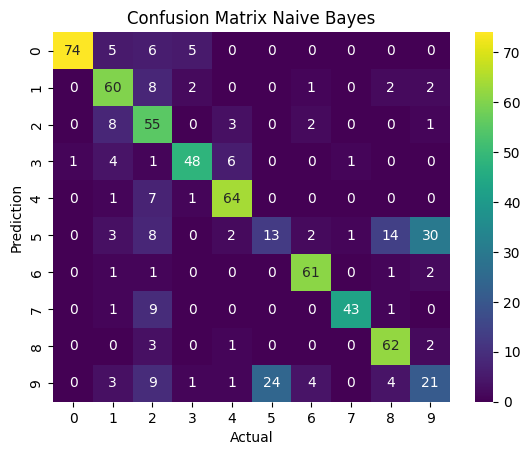

Accuracy Native Bayes: 0.7198275862068966
Recall Native Bayes: 0.720673970018914
Precision Native Bayes: 0.7150133553134786
F1-Score Native Bayes: 0.7088102769507889


In [9]:
count_vect = CountVectorizer(min_df=3, analyzer=stem_rmv_punc)
map_row_to_class = {0:"basketball", 1:"baseball", 2:"tennis", 3:"football", 4:"soccer", 
                    5:"forest fire", 6:"flood", 7:"earthquake", 8:"drought", 9:"heatwave"}

classes = ['basketball', 'baseball', 'tennis', 'football', 'soccer', 
           'forest fire', 'flood', 'earthquake', 'drought', 'heatwave']

train_9, test_9 = train_test_split(df[["full_text","leaf_label"]], random_state=42, test_size=0.2)

train_9['full_text'] = train_9['full_text'].map(clean)
test_9['full_text'] = test_9["full_text"].map(clean)

train_9_counts = count_vect.fit_transform(train_9['full_text'])
test_9_counts = count_vect.transform(test_9['full_text'])

train_9_tfidf = tfidf_9.fit_transform(train_9_counts)
test_9_tfidf = tfidf_9.transform(test_9_counts)

train_9_LSI = svd_9.fit_transform(train_9_tfidf)
test_9_LSI = svd_9.transform(test_9_tfidf)

print('Count Vectorizer')
print(train_9_counts.shape)
print(test_9_counts.shape)
print('tfidf')
print(train_9_tfidf.shape)
print(test_9_tfidf.shape)
print('LSI')
print(train_9_LSI.shape)
print(test_9_LSI.shape)

nb_predicted = nb_9.fit(train_9_LSI, train_9['leaf_label']).predict(test_9_LSI)
cm = confusion_matrix(test_9['leaf_label'],nb_predicted, labels=classes)
sns.heatmap(cm,annot=True, cmap='viridis')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.title('Confusion Matrix Naive Bayes')
plt.show()

print("Accuracy Native Bayes:", accuracy_score(test_9['leaf_label'],nb_predicted))
print("Recall Native Bayes:", recall_score(test_9['leaf_label'],nb_predicted, labels = classes, average='macro'))
print("Precision Native Bayes:", precision_score(test_9['leaf_label'],nb_predicted, labels = classes, average='macro'))
print("F1-Score Native Bayes:", f1_score(test_9['leaf_label'],nb_predicted, labels = classes, average='macro'))


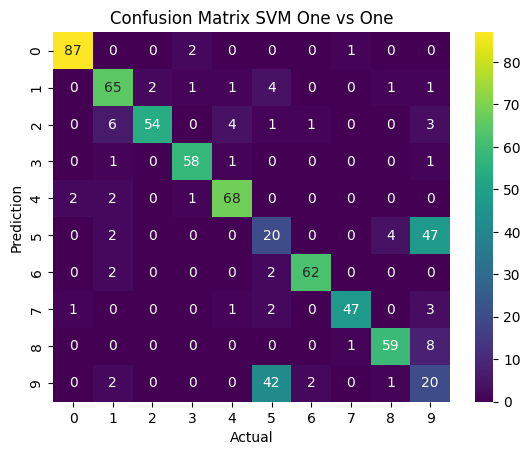

Accuracy SVM One vs One: 0.7758620689655172
Recall SVM One vs One: 0.7748159984445856
Precision SVM One vs One: 0.7928979049861397
F1-Score SVM One vs One: 0.782223342817596


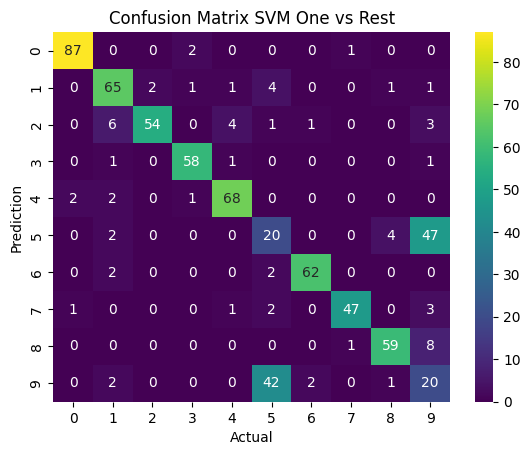

Accuracy SVM One vs One: 0.7758620689655172
Recall SVM One vs One: 0.7748159984445856
Precision SVM One vs One: 0.7928979049861397
F1-Score SVM One vs One: 0.782223342817596


In [10]:
confusion_metrics('Confusion Matrix SVM One vs One', 'ovo', classes, train_9, test_9, train_9_LSI, test_9_LSI)
confusion_metrics('Confusion Matrix SVM One vs Rest', 'ovr', classes, train_9, test_9, train_9_LSI, test_9_LSI)

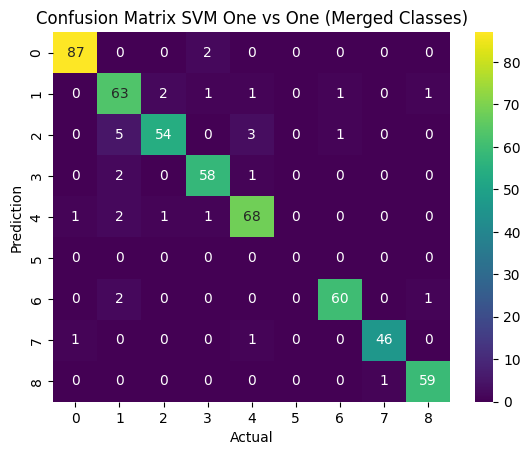

Accuracy SVM One vs One: 0.9008620689655172
Recall SVM One vs One: 0.7889101892812607
Precision SVM One vs One: 0.8254957887801828
F1-Score SVM One vs One: 0.8057816024757477


c:\Users\astro\repositories\UCLA\ECE 219\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\astro\repositories\UCLA\ECE 219\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\astro\repositories\UCLA\ECE 219\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

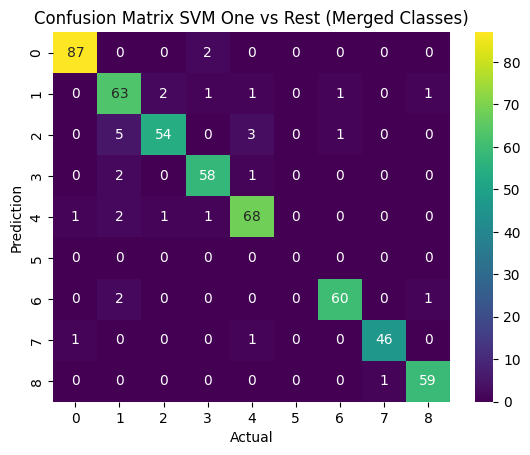

Accuracy SVM One vs One: 0.9008620689655172
Recall SVM One vs One: 0.7889101892812607
Precision SVM One vs One: 0.8254957887801828
F1-Score SVM One vs One: 0.8057816024757477


c:\Users\astro\repositories\UCLA\ECE 219\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\astro\repositories\UCLA\ECE 219\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\astro\repositories\UCLA\ECE 219\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

In [11]:
train_9['leaf_label'] = train_9['leaf_label'].replace('heatwave', 'hot')
train_9['leaf_label']= train_9['leaf_label'].replace('forest fire', 'hot')
test_9['leaf_label'] = test_9['leaf_label'].replace('heatwave', 'hot')
test_9['leaf_label'] = test_9['leaf_label'].replace('forest fire', 'hot')

merged_classes = ['basketball', 'baseball', 'tennis', 'football', 'soccer',
                  'fire', 'flood', 'earthquake', 'drought']

confusion_metrics('Confusion Matrix SVM One vs One (Merged Classes)', 'ovo', merged_classes, train_9, test_9, train_9_LSI, test_9_LSI)
confusion_metrics('Confusion Matrix SVM One vs Rest (Merged Classes)', 'ovr', merged_classes, train_9, test_9, train_9_LSI, test_9_LSI)

            full_text
leaf_label           
baseball          275
basketball        260
drought           258
earthquake        296
flood             284
football          289
hot               560
soccer            277
tennis            281
            full_text
leaf_label           
baseball           75
basketball         90
drought            68
earthquake         54
flood              66
football           61
hot               140
soccer             73
tennis             69
            full_text
leaf_label           
baseball          111
basketball        111
drought           111
earthquake        111
flood             111
football          111
hot               111
soccer            111
tennis            111
            full_text
leaf_label           
baseball           42
basketball         42
drought            42
earthquake         42
flood              42
football           42
hot                42
soccer             42
tennis             42


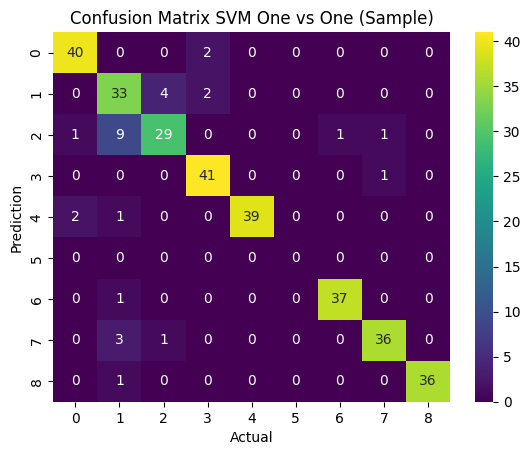

Accuracy SVM One vs One: 0.8703703703703703
Recall SVM One vs One: 0.7698412698412698
Precision SVM One vs One: 0.802660078041555
F1-Score SVM One vs One: 0.7837442924268058


c:\Users\astro\repositories\UCLA\ECE 219\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\astro\repositories\UCLA\ECE 219\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\astro\repositories\UCLA\ECE 219\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

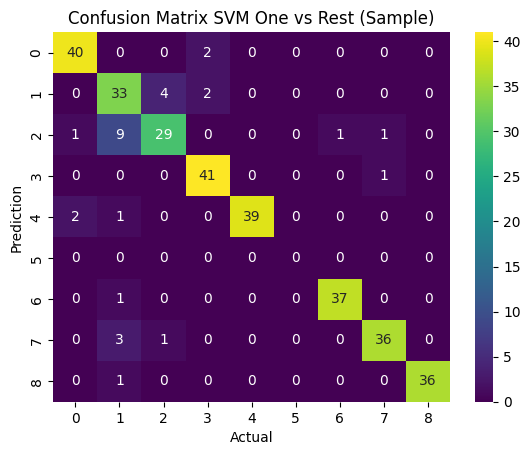

Accuracy SVM One vs One: 0.8703703703703703
Recall SVM One vs One: 0.7698412698412698
Precision SVM One vs One: 0.802660078041555
F1-Score SVM One vs One: 0.7837442924268058


c:\Users\astro\repositories\UCLA\ECE 219\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\astro\repositories\UCLA\ECE 219\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\astro\repositories\UCLA\ECE 219\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

In [12]:
print(train_9.groupby("leaf_label").count())
print(test_9.groupby("leaf_label").count())

train_sample = train_9.groupby("leaf_label").sample(n=111, random_state=42)
test_sample = test_9.groupby("leaf_label").sample(n=42, random_state=42)

print(train_sample.groupby("leaf_label").count())
print(test_sample.groupby("leaf_label").count())

train_sample_counts = count_vect.fit_transform(train_sample['full_text'])
test_sample_counts = count_vect.transform(test_sample['full_text'])

tfidf_second_9 = TfidfTransformer()
train_sample_tfidf = tfidf_second_9.fit_transform(train_sample_counts)
test_sample_tfidf = tfidf_second_9.transform(test_sample_counts)
svd_second_9 = TruncatedSVD(n_components=50, random_state=42)

train_sample_LSI = svd_second_9.fit_transform(train_sample_tfidf)
test_sample_LSI = svd_second_9.transform(test_sample_tfidf)

confusion_metrics('Confusion Matrix SVM One vs One (Sample)', 'ovo', merged_classes, train_sample, test_sample, train_sample_LSI, test_sample_LSI)
confusion_metrics('Confusion Matrix SVM One vs Rest (Sample)', 'ovr', merged_classes, train_sample, test_sample, train_sample_LSI, test_sample_LSI)

- Bullet 1, Question 9
  - In order to overcome the challenge of class imbalance amoung our features, we instead take a subset of each feature of the same size across all possible features when performing Naive Bayes and SVM classification
- Bullet 2, Question 9
  - In our Naive Bayes classification method, we can observe a distinct, correlation along the diagonal, demonstrating that our model prediction indeed match with the actual classes. However, features 5 and 9, that correspond to forest fire and heatwave respectively are often miss classified in comparison to the rest of the features.
- Bullet 3, Question 9
  - From our observations, we should attempt to merge features 5 and 9 as they are predicted fairly inaccuratly in comparison to the other available features. When merged we can observe that the merged feature is far more accurate, and enables us to make better predictions overall which is evident by the increased accuracy score in the merged case of 90% compared to the original 78% score
- Bullet 4, Question 9
  - Class imbalances can have negative impacts on the performance of our model, because the skewed data may bias our model, allowing it to retain a modest accuracy score, but likely does not perform well on different datasets.

### QUESTION 10: Read the paper about GLoVE embeddings - found here and answer the following subquestions:
a. Why are GLoVE embeddings trained on the ratio of co-occurrence probabilities rather than
the probabilities themselves?

b. In the two sentences: “James is running in the park.” and “James is running for the
presidency.”, would GLoVE embeddings return the same vector for the word running in both
cases? Why or why not?

c. What do you expect for the values of,
||GLoVE["left"] - $GLoVE["right"]||_2$, ||GLoVE["wife"] - $GLoVE["husband"]||_2$ and
||GLoVE["wife"] - $GLoVE["orange"]||_2$ ? Compare these values.

d. Given a word, would you rather stem or lemmatize the word before mapping it to its GLoVE
embedding?

In [13]:
# Code for Question 11
embeddings_dict = {}
dimension_of_glove = 300
with open("glove.6B.300d.txt", 'r', encoding='utf-8') as f: # if 'r' fails with unicode ,→ error, please use 'rb'
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

arr1 = [embeddings_dict["woman"] - embeddings_dict["man"]]
arr2 = [embeddings_dict["wife"] - embeddings_dict["husband"]]
arr3 = [embeddings_dict["wife"] - embeddings_dict["orange"]]
norm_1 = np.linalg.norm(arr1)
norm_2 = np.linalg.norm(arr2)
norm_3 = np.linalg.norm(arr3)


print("woman - man ", norm_1)
print("wife - husband : ", norm_2)
print("wife - orange : ", norm_3)

woman - man  4.7539396
wife - husband :  3.1520464
wife - orange :  8.667715


a. GLoVE embeddings are trained on the ratio of co-occurrence probabilities because this allows the model to better distinguish between important words as well as draw connections between words that have close relationships and vice-versa

b. Yes, GloVE would return the same vector, because the algorithm is context independent and represents all possible meanings for a particular word of interest

c. Based on GLoVE's design, we would anticipate that the difference between left and right, and wife and husband be a relatively small difference because they are semantically similar but differ in subtle ways, while the difference between wife and orange will be relatively large, as these words hold little in common with each other.

d. When given a word and using GLoVE, it's better to lemmatize the word before mapping, as stemming may result in invalid words, furthermore lemmatizing may allow us to reduce the noise present in our dataset.

### QUESTION 11: For the binary classification task distinguishing the “sports” class and “climate” class:
a. Describe a feature engineering process that uses GLoVE word embeddings to represent each
document. You have to abide by the following rules:

- A representation of a text segment needs to have a vector dimension that CANNOT
exceed the dimension of the GLoVE embedding used per word of the segment.
- You cannot use TF-IDF scores (or any measure that requires looking at the complete
dataset) as a pre-processing routine.
- Important: In this section, feel free to use raw features from any column in the original
data file not just full text. The column keywords might be useful... or not. Make
sure that your result achieves an accuracy of at least 92%.
- To aggregate these words into a single vector consider normalization the vectors, averaging
across the vectors.

b. Select a classifier model, train and evaluate it with your GLoVE-based feature. If you are doing
any cross-validation, please make sure to use a limited set of options so that your code finishes
running in a reasonable amount of time.

In [14]:
import string
from sklearn.preprocessing import LabelEncoder

# Code for Question 11
train_11, test_11 = train_test_split(df[["full_text","root_label", "keywords"]], test_size=0.2, random_state=42)
train_11['full_text'] = train_11['full_text'].apply(clean)
test_11['full_text'] = test_11['full_text'].apply(clean)

def preprocess_text(text, stop_words):
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return tokens

def glove_transform(full_text, keywords, embeddings_dict, stop_words, dimension_of_glove):
    tokens = preprocess_text(full_text, stop_words)
    embeddings = [embeddings_dict[word] for word in tokens if word in embeddings_dict]
    
    for keyword in keywords:
        if keyword in embeddings_dict:
            embeddings.append(2.0 * embeddings_dict[keyword])
    
    embeddings = np.array(embeddings)
    embeddings /= np.linalg.norm(embeddings, axis=1, keepdims=True)
    return np.mean(embeddings, axis=0)[:dimension_of_glove]

train_11['glove_features'] = train_11.apply(lambda row: glove_transform(row['full_text'], row['keywords'], embeddings_dict, stop_words_en, dimension_of_glove), axis=1)
test_11['glove_features'] = test_11.apply(lambda row: glove_transform(row['full_text'], row['keywords'], embeddings_dict, stop_words_en, dimension_of_glove), axis=1)

train_features = np.vstack(train_11['glove_features'].values)
test_features = np.vstack(test_11['glove_features'].values)

Encoder = LabelEncoder()
train_11['encoded_root_label']=Encoder.fit_transform(train_11['root_label'])
test_11['encoded_root_label']=Encoder.fit_transform(test_11['root_label'])

gloveSVM = LinearSVC(C=100, max_iter=10000, random_state=42)
gSVM_predictions = gloveSVM.fit(train_features, train_11['encoded_root_label']).predict(test_features)

print("GLoVE embedding prediction resutls")
print("Accuracy Glove-SVM:", accuracy_score(test_11['encoded_root_label'],gSVM_predictions))
print("Recall Glove-SVM::", recall_score(test_11['encoded_root_label'],gSVM_predictions, average='macro'))
print("Precision Glove-SVM::", precision_score(test_11['encoded_root_label'],gSVM_predictions,average='macro'))
print("F1-Score Glove-SVM::", f1_score(test_11['encoded_root_label'],gSVM_predictions,  average='macro'))

GLoVE embedding prediction resutls
Accuracy Glove-SVM: 0.9655172413793104
Recall Glove-SVM:: 0.9659000530222693
Precision Glove-SVM:: 0.9651139709531213
F1-Score Glove-SVM:: 0.9654347556180938


11a. We first accomplish this goal by splitting our "full_text", "keyword", and "root_label" features into a train, test split as previously preformed in the code. These splits are then cleaned and inputed to a simple text processer. This processor enabled us to tokenize our data from the "full_text" and "keywords" feature to create a "glove_feature" based on the matched found across the word embeddings and the data itself is then averaged and used in tandem with an encoded feature based on our "root_label" feature. These to datasets are then fitted using the LinearSVC function.

11b. The results of our experiments yieled the following (random_state=42):
    
Accuracy Glove-SVM: 0.9655172413793104

Recall Glove-SVM:: 0.9659000530222693

Precision Glove-SVM:: 0.9651139709531213

F1-Score Glove-SVM:: 0.9654347556180938

### QUESTION 12: Graphing 
Plot the relationship between the dimension of the pre-trained GLoVE embedding
and the resulting accuracy of the model in the classification task. Describe the observed trend. Is
this trend expected? Why or why not? In this part use the different sets of GLoVE vectors from the
link.

Training for:  glove.6B.50d.txt
Training for:  glove.6B.100d.txt
Training for:  glove.6B.200d.txt
Training for:  glove.6B.300d.txt


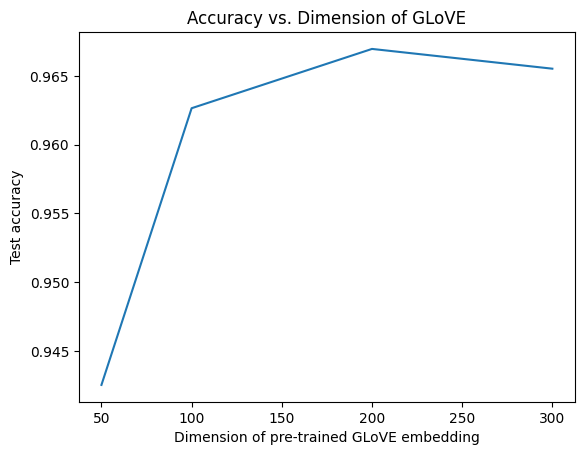

In [15]:
# Code for Question 12
dim_list = [50,100,200,300]
filenames_glove = ['glove.6B.50d.txt','glove.6B.100d.txt','glove.6B.200d.txt','glove.6B.300d.txt']
accuracys = []
i = 0
for filename in filenames_glove:
    train_temp, test_temp = train_test_split(df[["full_text","root_label", "keywords"]], test_size=0.2, random_state=42)
    train_temp['full_text'] = train_temp['full_text'].apply(clean)
    test_temp['full_text'] = test_temp['full_text'].apply(clean)
    
    print('Training for: ', filename)
    embeddings_dict = {}
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector

    train_temp['glove_features'] = train_temp.apply(lambda row: glove_transform(row['full_text'], row['keywords'], embeddings_dict, stop_words_en, dim_list[i]), axis=1)
    test_temp['glove_features'] = test_temp.apply(lambda row: glove_transform(row['full_text'], row['keywords'], embeddings_dict, stop_words_en, dim_list[i]), axis=1)

    train_features = np.vstack(train_temp['glove_features'].values)
    test_features = np.vstack(test_temp['glove_features'].values)

    Encoder = LabelEncoder()
    train_temp['encoded_root_label']=Encoder.fit_transform(train_temp['root_label'])
    test_temp['encoded_root_label']=Encoder.fit_transform(test_temp['root_label'])

    gloveSVM = LinearSVC(C=100, max_iter=10000, random_state=42)
    gSVM_predictions = gloveSVM.fit(train_features, train_temp['encoded_root_label']).predict(test_features)
    accuracys.append(accuracy_score(test_temp['encoded_root_label'],gSVM_predictions))
    i += 1


plt.plot(dim_list,accuracys)
plt.title('Accuracy vs. Dimension of GLoVE')
plt.xlabel('Dimension of pre-trained GLoVE embedding')
plt.ylabel('Test accuracy')
plt.show()

- Question 12
  - We can observe that as the dimension of our GLoVE function increases, our accuracy will also increase when using the LinearSVM Classifier function, as a higher dimentionality enables us to create better predictions as we have more information is captrured by our embeddings.

### QUESTION 13: Compare and contrast the two visualizations. 
Are there clusters formed in either or both of the plots? We will pursue the clustering aspect further in the next project.

c:\Users\astro\repositories\UCLA\ECE 219\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\astro\repositories\UCLA\ECE 219\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


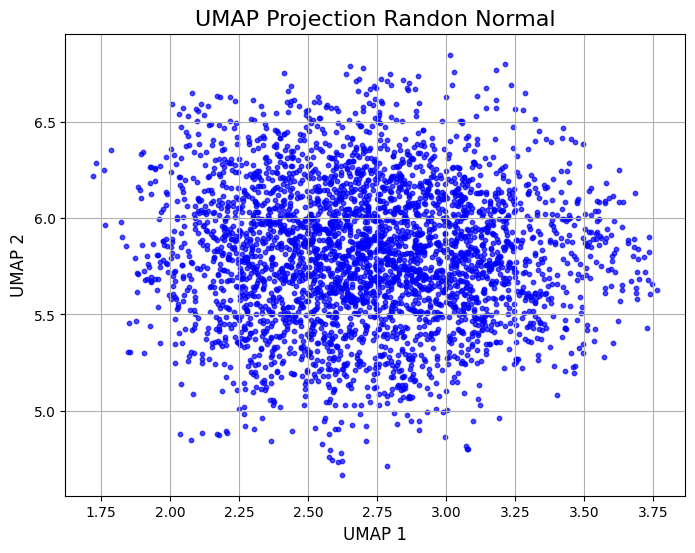

In [16]:
# Code for Question 13
from umap import UMAP

random_vectors = np.random.normal(0, 1, (len(df), dimension_of_glove))
random_vectors_norm = random_vectors / np.linalg.norm(random_vectors, axis=1)[:, np.newaxis]

umap_reducer = UMAP(n_components=10, metric='euclidean')
umap_embeddings = umap_reducer.fit_transform(random_vectors_norm)


plt.figure(figsize=(8, 6))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=10, c='blue', alpha=0.7)
plt.title("UMAP Projection Randon Normal", fontsize=16)
plt.xlabel("UMAP 1", fontsize=12)
plt.ylabel("UMAP 2", fontsize=12)
plt.grid(True)
plt.show()

c:\Users\astro\repositories\UCLA\ECE 219\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


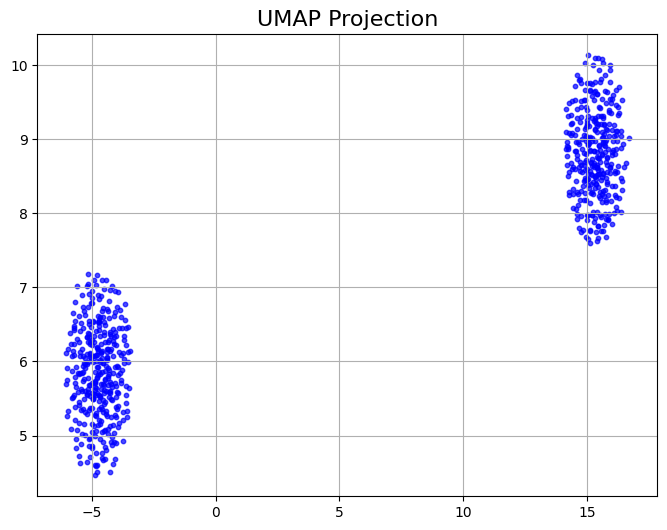

In [26]:
glove_umap = UMAP(n_components=2, metric='euclidean')
glove_embeddings_umap = glove_umap.fit_transform(gSVM_predictions.reshape(-1, 1))

plt.figure(figsize=(8, 6))
plt.scatter(glove_embeddings_umap[:, 0], glove_embeddings_umap[:, 1], s=10, c='blue', alpha=0.7)
plt.title("UMAP Projection", fontsize=16)
plt.grid(True)
plt.show()

 - Question 13
   - We can see that for the clove model, we observe distinct groupings of our classes, but in the case for a random normal dataset, the graph is distributed evenly, which demonstrates that glove can accuratly distinguish between our two classes in the root_label dataset